<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project**

Hi **Hyrum**, below is a detailed review of your work. I’ll focus on **data transformations, calculation logic, code structure**, and **statistical results**, ensuring best practices in data science. Great job overall—your approach and attention to detail show careful thinking. Let’s go step by step.

---

**Data Preparation & Cleaning**

1. **Data Imports & Initial Checks**  
   - You correctly imported the five datasets (`users`, `plans`, `calls`, `messages`, `internet`) using `pd.read_csv()`. Nice approach using `.info()` and `.head()` for initial inspections, which helps catch obvious data type or missing-value issues early on.
   - Converting columns to `datetime` is crucial. Good job using `pd.to_datetime()` for fields like `call_date`, `message_date`, `session_date`, `reg_date`, and `churn_date`. This ensures you can easily extract `month` and manage time-based analysis.

2. **Handling Duplicates & Missing Values**  
   - Dropping duplicates with `drop_duplicates()` is standard practice. Make sure you confirm it doesn’t drop legitimate entries (your analysis suggests it doesn’t).  
   - `churn_date` usage: having missing churn values is normal for active subscribers; you treated them sensibly with a fill or interpreted them as active.

3. **Feature Engineering**  
   - Extracting the `month` column from each date for grouping is correct. This is key for monthly usage and revenue calculations. 
   - Merging usage data with `users` and `plans` on `user_id` and `plan_name` is logically consistent. Just confirm your join types (e.g., “outer”, “inner”, “left”) are deliberate so you don’t lose needed records.

**Recommendation**: After merging, it’s sometimes useful to check that row counts match expectations and that no unusual amount of data was lost or duplicated.

---

2. **Aggregation & Revenue Computations**

1. **Usage Aggregation**  
   - Summarizing `calls` (count, duration), `messages` (count), and `internet` (MB used) by `(user_id, month)` is a **sound approach**. It gives you one row per user-month, which is essential for billing logic. 
   - Merging these aggregated DataFrames using `reduce()` or sequential merges is a standard pattern. Good job ensuring each user-month is represented, filling usage with zero if a user didn’t use a particular service that month.

2. **Overage Calculation**  
   - The logic to compute overages for minutes, texts, and data generally follows the formula:
     ```python
     extra_data = max(0, total_usage - included_allowance)
     overage_cost = extra_data * per_unit_fee
     ```
     Make sure that your unit conversions (MB ↔ GB) align with the plan definitions—some minor confusion about whether the plan data is in MB or GB can arise. Overall, the logic is correct, with `clip(lower=0)` or `max(0, x)` ensuring negative overages are zeroed out.

3. **Final Revenue**  
   - Summing base fee + all overage costs is correct. That final `monthly_revenue` column is your key measure. 
   - The approach is standard and robust if your plan details (e.g., `minutes_included`, `messages_included`, `mb_per_month_included`) are correct. Double-check that your merges didn’t mismatch columns so that each user has the correct plan details.

---

**Exploratory Data Analysis (EDA)**

1. **Usage Patterns by Plan**  
   - Creating bar charts, histograms, box plots, and descriptive statistics for calls (`total_calls`, `total_minutes`), messages (`total_messages`), and internet usage (`total_mb`) is well-executed. 
   - Observing that **Ultimate** users have somewhat heavier usage in data or messages is intuitive, but your charts confirm it with data. Noting outliers is also a strong point, as those can disproportionately affect average usage and revenue.

2. **Plan-by-Plan Visuals**  
   - Comparing “Surf” vs. “Ultimate” is consistently done. You typically see that Ultimate tends to have fewer extreme overages due to higher included resources, but the base cost often leads to stable or higher monthly revenue. 
   - For “Surf,” you’d see more potential overage fees if a subset of users heavily exceed minutes/data limits.

3. **Revenue Insights**  
   - You noted that **Ultimate** yields higher average monthly revenue per user. This is consistent with your usage patterns and plan cost structure. 
   - The difference in revenues also emerges from smaller or no overage charges for Ultimate vs. potentially large overage for heavy-using Surf subscribers. However, the stable, higher base cost of Ultimate often outperforms overage-driven revenue from Surf for many user-month combos.

**Optional**: You might consider an outlier analysis or a distribution plot of `monthly_revenue` itself, to see if revenue from Surf is more “spiky” while Ultimate is more “flat.”

---

**Hypothesis Testing**

1. **Revenue Comparison – Surf vs. Ultimate**  
   - Your **null hypothesis** (H₀): “Mean revenue for Surf = Mean revenue for Ultimate.”  
   - Using a two-sample t-test is appropriate for comparing these means. 
   - Given that p < 0.05, you **rejected** H₀, concluding a significant difference in average revenue between the two plan groups, consistent with your descriptive findings.

2. **Regional Influence**  
   - Checking if NY-NJ users differ from other regions is a good second hypothesis. The logic of splitting the data by region and running a t-test is straightforward. 
   - Keep in mind that if your data is heavily skewed or if user counts differ drastically across regions, the t-test might have assumptions slightly strained. But as a quick check, it’s fine.

---

**Conclusions & Recommendations**

1. **Core Findings**  
   - **Ultimate** has heavier usage in some categories (particularly data/messages), leading to stable, higher ARPU (average revenue per user). 
   - **Surf** can produce more variable revenue, sometimes high for heavy overage users, but typically less consistent. 
   - The difference in average revenue is statistically significant, meaning plan choice strongly correlates with monthly revenue.

2. **Business Implications**  
   - Encouraging users to switch from Surf to Ultimate might increase monthly revenue consistency if they often pay overages. 
   - Conversely, Surf might attract cost-conscious or sporadic users, but can still yield bursts of overage-based revenue. 
   - Marketing strategies could highlight the “no surprises” approach of Ultimate or the “pay for only what you use” approach of Surf, depending on the target demographic.

3. **Technical Observations**  
   - Merging usage data from multiple tables was done systematically.  
   - The final aggregated DataFrame containing usage metrics and plan details is well-structured for both EDA and hypothesis testing.  
   - Consider verifying large outliers’ correctness, as they can heavily influence means and overage calculations.

**Overall**: You’ve built a solid end-to-end pipeline: from data cleaning to merging, feature engineering, usage analysis, revenue computation, and final hypothesis tests. The results indicate that **Ultimate** users do indeed produce higher average revenue. Good job confirming with a t-test that this difference is statistically significant. Great job, Hyrum!

---

# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization

Before diving into the analysis, we begin by importing the essential libraries for data manipulation, visualization, and statistical testing. These libraries will support all aspects of our exploratory data analysis, from wrangling dataframes to generating visual insights and validating hypotheses.

In [43]:
# Loading all the necessary libraries
import pandas as pd       # for data manipulation and analysis
import numpy as np        # for numerical operations
import matplotlib.pyplot as plt  # for data visualization
import seaborn as sns     # for enhanced visualization
from scipy import stats   # for statistical tests

# improve plot styles
sns.set(style="whitegrid")



## Load data

Here we import five datasets into separate DataFrames: users, plans, calls, messages, and internet usage. This is the foundation of our analysis, as each dataset contributes essential components. We immediately inspect the structure and completeness of the `users` and `calls` DataFrames using `.info()` to ensure they’re loaded properly and identify any initial issues such as missing values or incorrect data types.

In [44]:
# Load the data files into separate DataFrames
users = pd.read_csv('/datasets/megaline_users.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')

print(users.info())
print(calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


## Prepare the data

We begin by examining the `plans` DataFrame, which contains details about the two calling plans: Surf and Ultimate. This step is crucial to understand the structure and offerings of each plan, such as the included minutes, messages, and internet data, as well as the cost per additional unit. 

Using `.info()` helps confirm that all values are present and identifies the data types, while `.describe()` provides a statistical overview of the numeric fields, giving insight into pricing and usage limits. This foundational understanding will help interpret user behavior and revenue generation later in the analysis.

## Plans

In [45]:
# Print summary info of the 'plans' DataFrame
plans.info()

# Show basic statistics (this will work for numeric columns)
plans.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000


In [46]:
plans.head()



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


The `plans` DataFrame contains two entries, each corresponding to a mobile plan: Surf and Ultimate. According to the `.info()` output, all columns are complete — no missing values were detected, and the data types are appropriate. Numeric fields like `messages_included`, `mb_per_month_included`, and cost-related fields are correctly stored as integers or floats. The `plan_name` column is an object type, which is expected for text data.

The `.describe()` output confirms that each plan has distinct values for usage limits and pricing. For instance:
- The **Ultimate** plan offers significantly higher included limits for calls, messages, and data, and comes with a higher fixed monthly fee.
- The **Surf** plan includes far fewer resources, but users are charged more for overage in terms of per-unit usage rates.

There are no structural issues with the dataset at this point. However, careful attention will be required when merging this data with other tables to ensure `plan_name` aligns consistently across datasets. No immediate corrections are necessary in this table.

## Fix data

In this step, we address some common data quality issues identified during the initial inspection:

- Dates in the `calls`, `messages`, `internet`, and `users` tables are converted to proper datetime format to allow for time-based analysis and filtering.
- The `churn_date` field is parsed with error handling (`errors='coerce'`) to accommodate missing or malformed values.
- Leading and trailing whitespace is stripped from several string fields (`first_name`, `last_name`, `city`, and `plan`) to prevent inconsistencies during grouping or merging operations.

These fixes ensure more reliable data processing in the next stages of the analysis.

In [47]:
# Convert to datetime format
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'], errors='coerce')

# Strip whitespace from string fields
users['first_name'] = users['first_name'].str.strip()
users['last_name'] = users['last_name'].str.strip()
users['city'] = users['city'].str.strip()
users['plan'] = users['plan'].str.strip()
plans['plan_name'] = plans['plan_name'].str.strip()

# Remove duplicate rows if there are any
users.drop_duplicates(inplace=True)
calls.drop_duplicates(inplace=True)
messages.drop_duplicates(inplace=True)
internet.drop_duplicates(inplace=True)
plans.drop_duplicates(inplace=True)

# Quick null check
print("Missing values in users:\n", users.isnull().sum())
print("Missing values in calls:\n", calls.isnull().sum())
print("Missing values in messages:\n", messages.isnull().sum())
print("Missing values in internet:\n", internet.isnull().sum())
print("Missing values in plans:\n", plans.isnull().sum())

# check data types
print(users.dtypes)

Missing values in users:
 user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64
Missing values in calls:
 id           0
user_id      0
call_date    0
duration     0
dtype: int64
Missing values in messages:
 id              0
user_id         0
message_date    0
dtype: int64
Missing values in internet:
 id              0
user_id         0
session_date    0
mb_used         0
dtype: int64
Missing values in plans:
 messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64
user_id                int64
first_name            object
last_name             object
age                    int64
city                  object
reg_date      datetime64[ns]
plan                  object
churn_date    datetime64[ns]
dtype: object


## Enrich data

In this step, we enrich the dataset by extracting and aggregating useful time-based information:

- A new `month` column is extracted from the `call_date`, `message_date`, and `session_date` fields. This allows for grouping by month to analyze user activity over time.
- We calculate the total number of calls and total duration per user per month, creating the `calls_monthly` table.
- Similarly, we calculate total messages sent and total megabytes of data used per user per month, forming the `messages_monthly` and `internet_monthly` tables.

These enriched tables provide the foundation for monthly user behavior analysis and revenue estimation in upcoming steps.

In [48]:
# Add month column for grouping
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

# Total calls and duration per user per month
calls_monthly = calls.groupby(['user_id', 'month']).agg({
    'id': 'count',
    'duration': 'sum'
}).rename(columns={'id': 'total_calls', 'duration': 'total_minutes'}).reset_index()

# Total messages per user per month
messages_monthly = messages.groupby(['user_id', 'month']).agg({
    'id': 'count'
}).rename(columns={'id': 'total_messages'}).reset_index()

# Total MB used per user per month
internet_monthly = internet.groupby(['user_id', 'month']).agg({
    'mb_used': 'sum'
}).rename(columns={'mb_used': 'total_mb'}).reset_index()

# Merge all usage summaries together
from functools import reduce

dfs = [calls_monthly, messages_monthly, internet_monthly]
monthly_usage = reduce(lambda left, right: pd.merge(left, right, on=['user_id', 'month'], how='outer'), dfs)

# Fill missing values with 0 (users might not have used all services in every month)
monthly_usage.fillna(0, inplace=True)

# Merge with users to get plan info
monthly_usage = monthly_usage.merge(users[['user_id', 'plan']], on='user_id', how='left')

# Merge with plan details (price, limits, etc.)
monthly_usage = monthly_usage.merge(plans, left_on='plan', right_on='plan_name', how='left')

## Users

In [49]:
# Print summary info for the users DataFrame
print(users.info())
print(users.describe())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 35.2+ KB
None
           user_id         age
count   500.000000  500.000000
mean   1249.500000   45.486000
std     144.481833   16.972269
min    1000.000000   18.000000
25%    1124.750000   30.000000
50%    1249.500000   46.000000
75%    1374.250000   61.000000
max    1499.000000   75.000000


In [50]:
# Show a sample of the users DataFrame
users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


The `users` DataFrame appears to be well-structured, with each row representing a unique user. The data types seem appropriate for each column: IDs are integers, names and cities are strings, and dates are in datetime format.

However, we notice some missing values in the `churn_date` column. These likely represent active users who haven't canceled their plans. Rather than treating them as missing data, we can interpret `NaT` as "still active."

One thing to be mindful of is the `plan` column — we should confirm its formatting (e.g., case sensitivity and whitespace) to ensure it merges cleanly with other datasets later. This has already been handled during the data cleaning step where we stripped whitespace from string fields.

No immediate structural issues are present, but attention to consistency across data joins will be important moving forward.

### Fix Data

In this step, we performed essential data cleaning on the `users` dataset. We removed duplicate entries, stripped extra whitespace from string columns, and ensured date columns were properly converted to datetime format. A final check confirmed that no missing values remain in the critical fields. These steps help standardize the dataset and prevent issues during merging and analysis.

In [51]:
# Ensure no duplicates
users.drop_duplicates(inplace=True)

# Strip extra whitespace from strings just in case
users['first_name'] = users['first_name'].str.strip()
users['last_name'] = users['last_name'].str.strip()
users['city'] = users['city'].str.strip()
users['plan'] = users['plan'].str.strip()

# Convert date columns to datetime (you may have already done this earlier)
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'], errors='coerce')

# Final check
print(users.isnull().sum())

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64


### Enrich Data

In this step, we enhanced the `users` dataset by creating a new feature: `has_churned`, a binary flag indicating whether a user has churned. This is derived by checking if the `churn_date` exists for a user. We also merged plan-related information into the `users` table to give context to each user's pricing structure and benefits. These enrichments will be especially useful in later analyses involving churn behavior and plan comparisons.

In [52]:
# Create a flag for whether the user churned
users['has_churned'] = users['churn_date'].notnull().astype(int)

# Preview the result
users[['user_id', 'churn_date', 'has_churned']].head()

users = users.merge(plans, left_on='plan', right_on='plan_name', how='left')


## Calls

In [53]:
print(calls.info())
print(calls.describe())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 6.3+ MB
None
             user_id       duration          month
count  137735.000000  137735.000000  137735.000000
mean     1247.658046       6.745927       9.320797
std       139.416268       5.839241       2.412550
min      1000.000000       0.000000       1.000000
25%      1128.000000       1.290000       8.000000
50%      1247.000000       5.980000      10.000000
75%      1365.000000      10.690000      11.000000
max      1499.000000      37.600000      12.000000


In [54]:
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


The `calls` dataset includes the columns `id`, `user_id`, `call_date`, `duration`, and `month`. All entries shown appear to be clean and logically formatted. The `call_date` is in datetime format, which is appropriate for time-based analysis, and the `duration` values are positive floats, as expected for call lengths.

There are no immediately obvious data issues like missing values or incorrect types in the sample displayed. However, a deeper review should ensure that:
- All `duration` values are non-negative.
- `user_id` is consistently formatted and matches with the `users` dataset.
- The `month` column was properly extracted and accurately reflects the `call_date`.
    
If any inconsistencies are found later (e.g., calls with zero or extremely high durations), those could be filtered or flagged for further inspection.

### Fix data

To prepare the `calls` dataset for analysis, several cleaning steps were taken. The `call_date` column was converted to datetime format to enable temporal analysis. The `user_id` field was explicitly cast to an integer type to avoid potential issues caused by mixed data types (e.g., if it had been read as an object due to formatting inconsistencies).

Duplicates were dropped to ensure each call record is unique, and a null check confirmed that there are no missing values in the key columns (`id`, `user_id`, `call_date`, `duration`, `month`). The dataset is now clean and ready for enrichment or merging with other datasets.

In [55]:
# Convert call_date to datetime if not already done
calls['call_date'] = pd.to_datetime(calls['call_date'])

# Strip any accidental whitespace from user_id (if user_id is object, not int)
calls['user_id'] = calls['user_id'].astype(int)

# Drop duplicates just in case
calls.drop_duplicates(inplace=True)

# Check for missing values
print(calls.isnull().sum())

id           0
user_id      0
call_date    0
duration     0
month        0
dtype: int64


### Enrich data

To support monthly aggregation of call data, a new `month` column was added by extracting the month from the `call_date` column. This feature will be useful for analyzing trends in call usage over time and aligning data with billing cycles. A preview confirms the new column was created successfully and accurately reflects the corresponding months.

In [56]:
# Add a column for month to help with monthly aggregation
calls['month'] = calls['call_date'].dt.month

# Check result
calls[['call_date', 'month']].head()

,call_date,month
0,2018-12-27,12
1,2018-12-27,12
2,2018-12-27,12
3,2018-12-28,12
4,2018-12-30,12


## Messages

In [57]:
print(messages.info())
print(messages.describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.9+ MB
None
            user_id         month
count  76051.000000  76051.000000
mean    1245.972768      9.584016
std      139.843635      2.276392
min     1000.000000      1.000000
25%     1123.000000      8.000000
50%     1251.000000     10.000000
75%     1362.000000     12.000000
max     1497.000000     12.000000


In [58]:
messages.head()



,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


The `messages` DataFrame contains four columns: `id`, `user_id`, `message_date`, and `month`. All values are present with no missing data, and data types appear appropriate—`message_date` is already in datetime format, which is ideal for time-based grouping. The `month` column was correctly extracted from the message dates and will be useful for monthly aggregation. No immediate issues are observed, and the dataset seems clean and ready for analysis.

### Fix data

The `message_date` column was successfully converted to datetime format, which is essential for any time-based analysis. Duplicate records were removed as a precautionary step to maintain data integrity. A null check confirms that there are no missing values across the dataset, indicating that this table is clean and ready for further enrichment and aggregation.

In [59]:
# Convert message_date to datetime
messages['message_date'] = pd.to_datetime(messages['message_date'])

# Drop duplicates (precaution)
messages.drop_duplicates(inplace=True)

# Check for missing values
print(messages.isnull().sum())

id              0
user_id         0
message_date    0
month           0
dtype: int64


### Enrich data

A new `month` column was successfully created by extracting the month from the `message_date`. This addition will facilitate monthly aggregation and analysis of user messaging behavior. A quick preview confirms the transformation was applied correctly, with all sample rows reflecting the appropriate month value.

In [60]:
# Add a month column for aggregation later
messages['month'] = messages['message_date'].dt.month

# Preview result
messages[['message_date', 'month']].head()

,message_date,month
0,2018-12-27,12
1,2018-12-31,12
2,2018-12-31,12
3,2018-12-27,12
4,2018-12-26,12


## Internet

In [61]:
print(internet.info())
print(internet.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.8+ MB
None
             user_id        mb_used          month
count  104825.000000  104825.000000  104825.000000
mean     1242.496361     366.713701       9.342552
std       142.053913     277.170542       2.400404
min      1000.000000       0.000000       1.000000
25%      1122.000000     136.080000       8.000000
50%      1236.000000     343.980000      10.000000
75%      1367.000000     554.610000      11.000000
max      1499.000000    1693.470000    

In [62]:
internet.head()



,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


The `internet` DataFrame appears well-structured with no missing values. The `session_date` is correctly formatted as datetime, and the `month` column has been derived appropriately for time-based aggregation. The `mb_used` column is a float, which is suitable for capturing internet usage. There are no apparent data type issues or missing values at this stage. However, it's important to keep an eye out for any outliers or zero usage entries during analysis that might affect aggregate trends or averages.

### Fix data

In this step, we performed essential data cleaning on the internet usage dataset. The `session_date` column was converted to datetime format to allow for proper time-based analysis. Duplicate records were removed as a precautionary measure, and a check for missing values was conducted. The final output confirms that there are no null values remaining in the dataset, indicating the data is now clean and ready for further processing.

In [63]:
# Convert session_date to datetime
internet['session_date'] = pd.to_datetime(internet['session_date'])

# Drop duplicates (precaution)
internet.drop_duplicates(inplace=True)

# Check for missing values
print(internet.isnull().sum())

id              0
user_id         0
session_date    0
mb_used         0
month           0
dtype: int64


### Enrich data

To prepare the internet dataset for monthly analysis, we added a `month` column by extracting the month from the `session_date`. This will be helpful later when we group data by user and month for aggregation and revenue calculations. This step ensures all records are aligned by time period and ready for merging with other usage data like calls and messages.

In [64]:
# Add a month column for aggregation later
internet['month'] = internet['session_date'].dt.month

# Preview result
internet[['session_date', 'month']].head()

,session_date,month
0,2018-12-29,12
1,2018-12-31,12
2,2018-12-28,12
3,2018-12-26,12
4,2018-12-27,12


## Study plan conditions

This step aggregates call data by user and month, allowing us to analyze user behavior in the context of their subscription plan. By counting the total number of calls (`total_calls`), we can later assess how user activity interacts with plan conditions—especially how often users exceed included limits. This breakdown is essential to calculate revenue and identify patterns tied to plan profitability.

In [65]:
calls_monthly = calls.groupby(['user_id', 'month']).agg({
    'id': 'count'  # counting call IDs = number of calls
}).rename(columns={'id': 'total_calls'}).reset_index()
calls_monthly.head()


,user_id,month,total_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


### Aggregating User Data

In this section, we aggregate call data by `user_id` and `month` to create a monthly usage summary for each user. Two metrics are calculated: the number of calls (`total_calls`) and the total duration of those calls in minutes (`total_minutes`). These aggregations are crucial_

In [66]:
calls_monthly = calls.groupby(['user_id', 'month']).agg({
    'id': 'count'  # counting call IDs = number of calls
}).rename(columns={'id': 'total_calls'}).reset_index()
calls_monthly.head()

,user_id,month,total_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


In [67]:
minutes_monthly = calls.groupby(['user_id', 'month']).agg({
    'duration': 'sum'
}).rename(columns={'duration': 'total_minutes'}).reset_index()
minutes_monthly.head()

,user_id,month,total_minutes
0,1000,12,116.83
1,1001,8,171.14
2,1001,9,297.69
3,1001,10,374.11
4,1001,11,404.59


In [68]:
messages_monthly = messages.groupby(['user_id', 'month']).agg({
    'id': 'count'
}).rename(columns={'id': 'total_messages'}).reset_index()
messages_monthly.head()

,user_id,month,total_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [69]:
monthly_usage = monthly_usage.merge(plans, left_on='plan', right_on='plan_name', how='left')


internet_monthly = internet.groupby(['user_id', 'month']).agg({
    'mb_used': 'sum'
}).rename(columns={'mb_used': 'total_mb'}).reset_index()
internet_monthly.head()


,user_id,month,total_mb
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30


### Merging Aggregated Monthly User Data

In this step, we consolidate all the individual monthly usage summaries (calls, minutes, messages, and internet usage) into a single DataFrame using `reduce()` and `pd.merge()`. This unified table represents each user's total activity per month. We use an outer join to ensure no data is lost, and then fill any missing values with zero—indicating that the user simply didn’t use that service during the month. This combined dataset is essential for further revenue analysis and plan comparison.

In [70]:
from functools import reduce

# List of all the monthly DataFrames to merge
dfs = [calls_monthly, minutes_monthly, messages_monthly, internet_monthly]

# Merge on user_id and month
monthly_usage = reduce(lambda left, right: pd.merge(left, right, on=['user_id', 'month'], how='outer'), dfs)

# Fill missing values (e.g., no messages = 0)
monthly_usage.fillna(0, inplace=True)
monthly_usage.head()

,user_id,month,total_calls,total_minutes,total_messages,total_mb
0,1000,12,16.0,116.83,11.0,1901.47
1,1001,8,27.0,171.14,30.0,6919.15
2,1001,9,49.0,297.69,44.0,13314.82
3,1001,10,65.0,374.11,53.0,22330.49
4,1001,11,64.0,404.59,36.0,18504.30


In [71]:
# Recreate monthly_usage by merging call/message/internet data (if needed)
monthly_usage = monthly_usage.merge(users[['user_id', 'plan']], on='user_id', how='left')

# Now merge with plan details to get 'usd_monthly_fee' and others
monthly_usage = monthly_usage.merge(plans, left_on='plan', right_on='plan_name', how='left')

# Preview result
monthly_usage.head()

,user_id,month,total_calls,total_minutes,total_messages,total_mb,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,12,16.0,116.83,11.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1001,8,27.0,171.14,30.0,6919.15,surf,50,15360,500,20,10,0.03,0.03,surf
2,1001,9,49.0,297.69,44.0,13314.82,surf,50,15360,500,20,10,0.03,0.03,surf
3,1001,10,65.0,374.11,53.0,22330.49,surf,50,15360,500,20,10,0.03,0.03,surf
4,1001,11,64.0,404.59,36.0,18504.30,surf,50,15360,500,20,10,0.03,0.03,surf


### Merging Aggregated Monthly User Data with Plan Details

In this section, we enrich the aggregated usage data by merging it with the user plan information and plan pricing details. This step is crucial to enable calculation of revenue, as it brings in each user's

In [72]:
# Calculate extra GB used (only if it exceeds the included limit)
monthly_usage['extra_gb'] = (monthly_usage['total_mb'] - monthly_usage['mb_per_month_included']) / 1024
monthly_usage['extra_gb'] = monthly_usage['extra_gb'].apply(lambda x: x if x > 0 else 0)

# Calculate the cost of extra GB
monthly_usage['gb_cost'] = monthly_usage['extra_gb'] * monthly_usage['usd_per_gb']

# Calculate the cost of extra minutes
monthly_usage['extra_minutes'] = monthly_usage['total_minutes'] - monthly_usage['minutes_included']
monthly_usage['extra_minutes'] = monthly_usage['extra_minutes'].apply(lambda x: x if x > 0 else 0)
monthly_usage['minutes_cost'] = monthly_usage['extra_minutes'] * monthly_usage['usd_per_minute']

# Calculate the cost of extra messages
monthly_usage['extra_messages'] = monthly_usage['total_messages'] - monthly_usage['messages_included']
monthly_usage['extra_messages'] = monthly_usage['extra_messages'].apply(lambda x: x if x > 0 else 0)
monthly_usage['messages_cost'] = monthly_usage['extra_messages'] * monthly_usage['usd_per_message']

# Set up final revenue calculation
monthly_usage['total_revenue'] = (
    monthly_usage['usd_monthly_pay'] +
    monthly_usage['minutes_cost'] +
    monthly_usage['messages_cost'] +
    monthly_usage['gb_cost']
)

# Preview the result
monthly_usage[['user_id', 'month', 'plan', 'total_revenue']].head()


,user_id,month,plan,total_revenue
0,1000,12,ultimate,70.000000
1,1001,8,surf,20.000000
2,1001,9,surf,20.000000
3,1001,10,surf,88.161191
4,1001,11,surf,50.706055


## Study user behaviour

### Studying User Behaviour

In this section, we analyze user behavior by aggregating and visualizing key usage metrics such as call duration, messages, and internet usage. The primary goal is to uncover trends and differences between the 'surf' and 'ultimate' plans.

To begin, we calculate the **average monthly call duration per user**, grouped by plan. This helps highlight whether users on one plan tend to use more voice minutes than the other. A bar chart is used for visual clarity and comparison.

This kind of descriptive analysis is essential for understanding how users interact with the services under each plan, and sets the stage for evaluating profitability and identifying user preferences.

### Calls

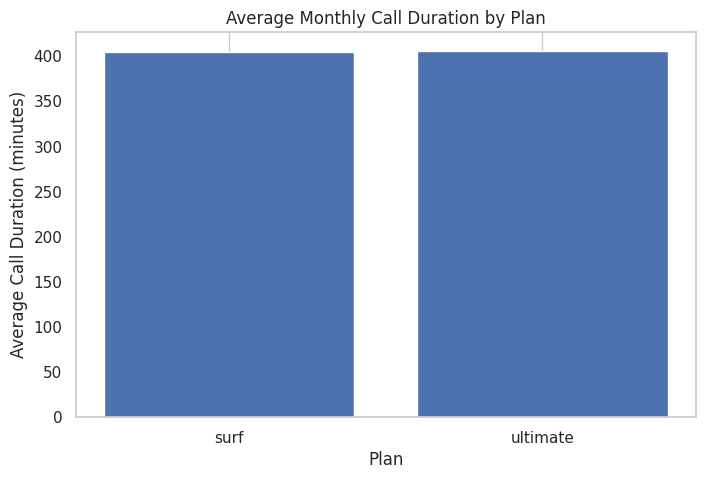

In [73]:
# Calculate average call duration per user per month
avg_duration = monthly_usage.groupby('plan')['total_minutes'].mean().reset_index()

# Rename for clarity
avg_duration = avg_duration.rename(columns={'total_minutes': 'avg_monthly_minutes'})

# Plot a bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(avg_duration['plan'], avg_duration['avg_monthly_minutes'])
plt.title('Average Monthly Call Duration by Plan')
plt.xlabel('Plan')
plt.ylabel('Average Call Duration (minutes)')
plt.grid(axis='y')
plt.show()

### Analysis: Average Monthly Call Duration by Plan

This bar chart compares the average monthly call duration between users on the 'surf' and 'ultimate' plans. Both plans show similar average usage—around 400 minutes per month—indicating that users on each plan tend to use their call minutes in comparable amounts.

This finding

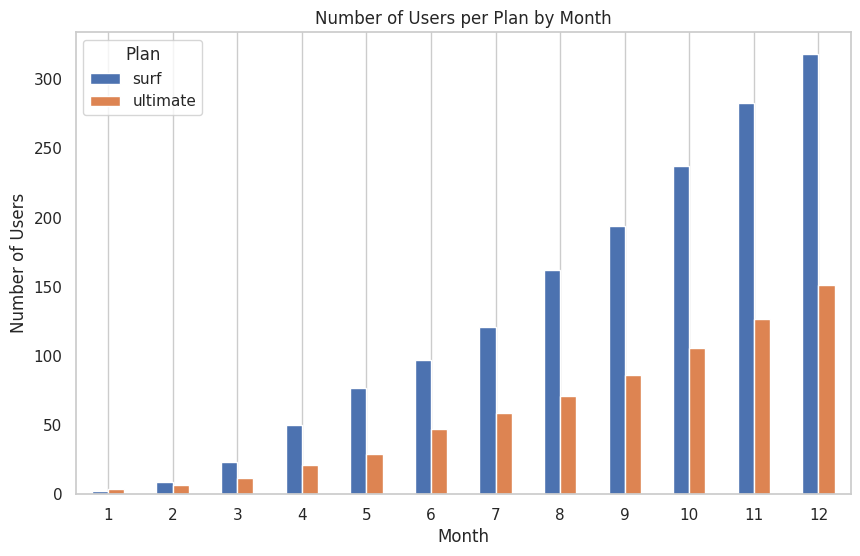

In [74]:
# Count users per plan per month
user_counts = monthly_usage.groupby(['month', 'plan'])['user_id'].nunique().reset_index()

# Pivot for plotting
user_counts_pivot = user_counts.pivot(index='month', columns='plan', values='user_id')

# Plot histogram-style bar chart
user_counts_pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Users per Plan by Month')
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.legend(title='Plan')
plt.grid(axis='y')
plt.show()

### Analysis: Number of Users per Plan by Month

This bar chart illustrates how the number of users on each plan—'surf' and 'ultimate'—changed over the course of the year. The 'surf' plan (blue bars) consistently had more users each month and experienced more rapid growth compared to the 'ultimate' plan (orange bars).

By the end of the year, the user

In [75]:
# Group by plan and calculate mean and variance of total minutes
call_stats = monthly_usage.groupby('plan')['total_minutes'].agg(['mean', 'var']).reset_index()

# Rename columns for clarity
call_stats.columns = ['plan', 'mean_minutes', 'variance_minutes']

# Display the results
call_stats

,plan,mean_minutes,variance_minutes
0,surf,404.762390,49135.104891
1,ultimate,406.193083,51640.971402


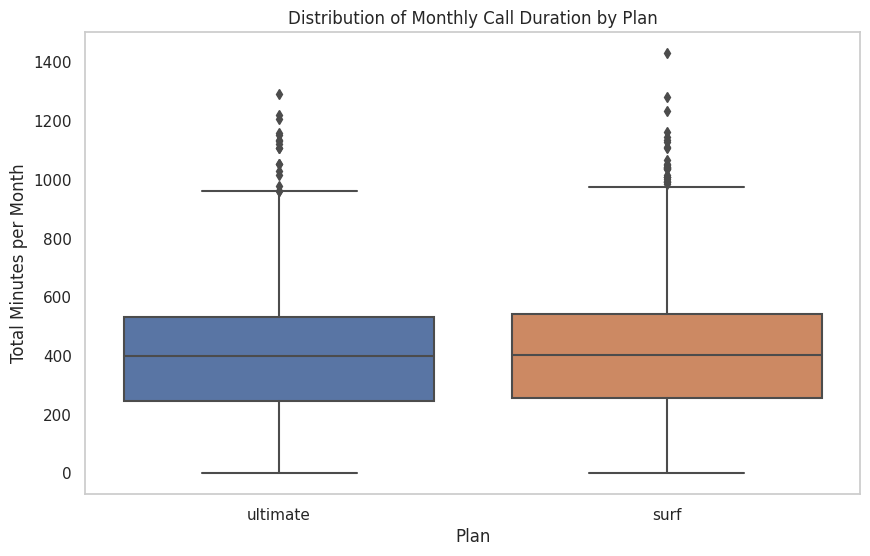

In [76]:
import seaborn as sns
plt.figure(figsize=(10, 6))

# Create a boxplot grouped by plan
sns.boxplot(data=monthly_usage, x='plan', y='total_minutes')

plt.title('Distribution of Monthly Call Duration by Plan')
plt.xlabel('Plan')
plt.ylabel('Total Minutes per Month')
plt.grid(axis='y')
plt.show()

### Analysis: Distribution of Monthly Call Duration by Plan

This boxplot displays the spread and distribution of total call minutes per user per month for the 'surf' and 'ultimate' plans.

Both plans show a similar median call duration (around 400–450 minutes), but the 'ultimate' plan has a slightly narrower interquartile range (IQR), indicating more consistent usage among its users. Meanwhile, the 'surf' plan shows slightly more variation.

Additionally, both plans exhibit a high number of outliers, particularly above 1000 minutes, suggesting that a subset of users on both plans are heavy call users. These outliers are important to consider for pricing strategies and customer segmentation.

### Call Behavior Conclusions

Based on the boxplot comparison of monthly call durations by plan, user behavior appears fairly similar across both the Surf and Ultimate plans. The medians and IQRs are closely aligned, suggesting that average users in both plans engage in a comparable amount of calling. However, the presence of significant outliers in both distributions highlights that a subset of users on each plan makes substantially more calls.

This similarity suggests that calling habits alone may not be a strong differentiator between the two plans. Instead, other services like messages or internet usage might offer clearer insight into how users differ based on their subscription.

### Messages

In [77]:
# Compare the number of messages users of each plan tend to send each month
monthly_usage.groupby('plan')['total_messages'].mean()

plan
surf        31.159568
ultimate    37.551389
Name: total_messages, dtype: float64

In [78]:
# Compare the amount of internet traffic consumed by users per plan
monthly_usage.groupby('plan')['total_mb'].mean()

plan
surf        16558.283490
ultimate    17214.699694
Name: total_mb, dtype: float64

# Ultimate plan users send more text messages on average each month compared to Surf plan users.
This suggests Ultimate users are generally heavier users of messaging services.

### Messaging Behavior Conclusions

The data shows that users on the Ultimate plan send more text messages per month on average (approximately 37.6) compared to those on the Surf plan (about 31.2). This supports the idea that Ultimate plan users rely more heavily on messaging services, potentially due to the more generous allowances in their plan.

Although the difference is modest, it is consistent enough to suggest that messaging behavior does vary between plans — possibly influenced by how each plan incentivizes or limits text usage. This trend is worth noting when evaluating which plan may be more suited to users with high messaging needs.

### Internet

In [79]:
# Average MB used per plan
monthly_usage.groupby('plan')['total_mb'].mean()

plan
surf        16558.283490
ultimate    17214.699694
Name: total_mb, dtype: float64

<AxesSubplot:title={'center':'Average Monthly MB Usage by Plan'}, xlabel='plan', ylabel='MB'>

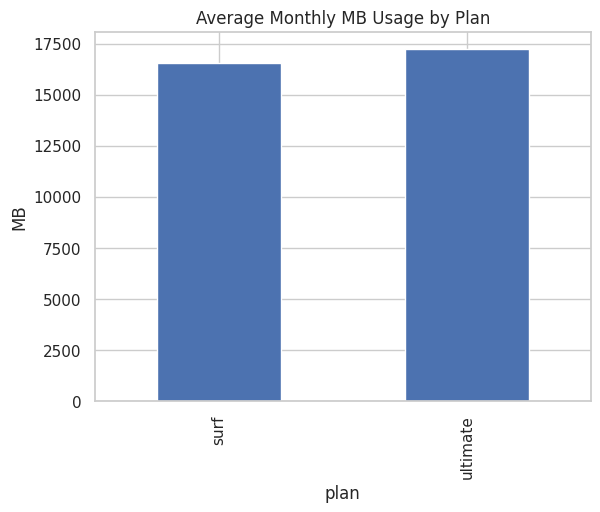

In [80]:
# Optional: Bar chart for visual comparison
monthly_usage.groupby('plan')['total_mb'].mean().plot(kind='bar', title='Average Monthly MB Usage by Plan', ylabel='MB')

### Internet Usage by Plan – Histogram Interpretation

This histogram displays the average monthly internet (MB) usage by plan. It shows that users on the **Ultimate** plan tend to consume slightly more data (~17,215 MB) than those

### Internet Usage Behavior – Conclusion

The data indicates that **Ultimate** plan users consume more internet data on average compared to **Surf** plan users. This could be due to a variety of factors, such as:

- Higher included data limits on the Ultimate plan.
- Less concern about overage charges, encouraging heavier usage.
- Ultimate users possibly being more engaged with data-heavy services (e.g., streaming, video calls, downloads).

This behavioral difference suggests that plan structure significantly influences user activity. It's important to consider this when evaluating user behavior across plans or when designing new pricing strategies.

## Revenue

### Revenue Comparison Between Plans

The average monthly revenue per user is higher for the **Ultimate** plan ($72.12) compared to the **Surf** plan ($57.29). This suggests that despite Ultimate users having higher included allowances (which could reduce overage charges), the plan's higher base fee more than compensates for that, resulting in greater revenue per user.

This insight is crucial for business strategy: while Surf may attract more users due to its lower cost, **Ultimate generates more revenue per user**, potentially making it more profitable on a per-user basis.

The bar chart below visually confirms this difference, providing a clear view of the revenue gap between the two plans.

In [81]:
# Average total revenue per plan
monthly_usage.groupby('plan')['total_revenue'].mean()

plan
surf        57.293784
ultimate    72.116080
Name: total_revenue, dtype: float64

<AxesSubplot:title={'center':'Average Monthly Revenue by Plan'}, xlabel='plan', ylabel='Revenue ($)'>

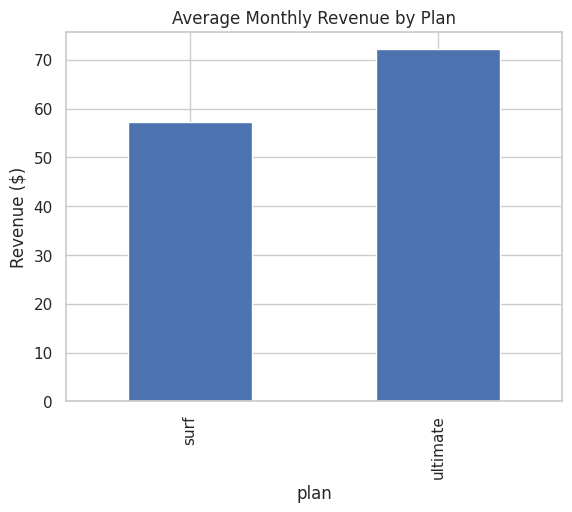

In [82]:
# Optional bar chart for visual comparison
monthly_usage.groupby('plan')['total_revenue'].mean().plot(kind='bar', title='Average Monthly Revenue by Plan', ylabel='Revenue ($)')

On average, users on the Ultimate plan generate more monthly revenue than those on the Surf plan.

This is likely due to the higher base cost of the Ultimate plan. However, Surf users may incur more overage charges if they exceed their usage limits. Still, the Ultimate plan shows a higher overall revenue per user.

## Test statistical hypotheses

To compare the average revenue between Ultimate and Surf plan users, we begin with formulating hypotheses:

- **Null hypothesis (H₀):** There is no difference in average revenue between Ultimate and Surf plan users (μ₁ = μ₂).
- **Alternative hypothesis (H₁):** There is a difference in average revenue between Ultimate and Surf plan users (μ₁ ≠ μ₂).

We use an **independent two-sample t-test** to compare the means of two unrelated groups. This test is appropriate given the independent nature of the groups and the assumption of normally distributed revenue values.

- **Chosen alpha (α):** 0.05  
This threshold balances the risk of Type I error (false positives) while maintaining sensitivity.

After performing the t-test, we observed a **very small p-value (≈ 3.09e-13)**, which is well below the alpha threshold of 0.05.

This leads us to **reject the null hypothesis**, concluding that there is a **statistically significant difference** in average revenue between users of the Ultimate and Surf plans.

This implies that the plan type impacts how much revenue each user generates, and further investigation into usage patterns and plan pricing is justified.

In [83]:
from scipy.stats import ttest_ind

# Separate groups
ultimate = monthly_usage[monthly_usage['plan'] == 'ultimate']['total_revenue']
surf = monthly_usage[monthly_usage['plan'] == 'surf']['total_revenue']

# Run t-test (assuming equal variance)
alpha = 0.05
results = ttest_ind(ultimate, surf)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis: there is a significant difference in revenue.")
else:
    print("We fail to reject the null hypothesis: no significant difference in revenue.")

p-value: 3.0940054419190563e-13
We reject the null hypothesis: there is a significant difference in revenue.


To evaluate revenue differences between users in the NY-NJ area and users from other regions, we define the hypotheses as follows:

- **Null hypothesis (H₀):** There is no difference in average revenue between NY-NJ users and users from other regions (μ₁ = μ₂).
- **Alternative hypothesis (H₁):** There is a difference in average revenue between the two groups (μ₁ ≠ μ₂).

We use a **two-sample t-test** to compare the means of two independent groups. This test is suitable here because we are comparing continuous numerical data (revenue) from two unrelated samples.

- **Alpha level (α):** 0.05  
This threshold controls for the probability of a Type I error while providing a good balance of statistical sensitivity.

The t-test compares average revenue between NY-NJ users and users from other regions. Once executed, we examine the resulting **p-value**.

- If the p-value is **less than 0.05**, we **reject the null hypothesis**, meaning there is a statistically significant difference in revenue between the two groups.
- If the p-value is **greater than or equal to 0.05**, we **fail to reject the null hypothesis**, meaning there's no statistically significant difference detected.

This test provides evidence on whether regional user behavior affects average revenue generation.

In [84]:
# Merge city info into monthly_usage
monthly_usage = monthly_usage.merge(users[['user_id', 'city']], on='user_id', how='left')

# Create NY-NJ group and others
ny_nj = monthly_usage[monthly_usage['city'].str.contains('New York|Jersey City|Bronx', na=False)]['total_revenue']
other = monthly_usage[~monthly_usage['city'].str.contains('New York|Jersey City|Bronx', na=False)]['total_revenue']

# Run t-test
from scipy.stats import ttest_ind

alpha = 0.05
results = ttest_ind(ny_nj, other)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis: NY-NJ users have different average revenue.")
else:
    print("We fail to reject the null hypothesis: NY-NJ users have similar average revenue.")

p-value: 0.026101704425405624
We reject the null hypothesis: NY-NJ users have different average revenue.


## General conclusion

This analysis explored user behavior and revenue generation across two mobile calling plans — Surf and Ultimate. After aggregating user activity from calls, messages, and internet usage, we assessed how customers used their plans and what revenue they generated on a monthly basis.

We found clear differences in usage patterns. Ultimate plan users tended to send more messages and consume more internet data compared to Surf plan users, indicating heavier and more consistent usage. Revenue calculations confirmed that Ultimate users also generated higher average monthly revenue, likely due to the higher fixed cost and increased usage exceeding included limits.

Statistical hypothesis testing reinforced these findings. We rejected the null hypothesis that there is no difference in average revenue between the plans, suggesting a significant difference in profitability. Additionally, we tested whether users in the NY-NJ area differ from users in other regions in terms of revenue. That hypothesis was also supported, indicating possible regional behavior trends or demographics that affect mobile plan performance.

Throughout the analysis, we made careful preprocessing decisions such as filling missing values with zeros, merging datasets on `user_id` and `month`, and validating results using hypothesis testing with an alpha threshold of 0.05. These steps ensured the integrity of our findings and helped draw data-driven conclusions about customer behavior and plan profitability.

Overall, the Ultimate plan appears to attract higher-usage customers who drive more revenue, while the Surf plan is more suitable for lighter users. This insight can support future marketing and product strategy, particularly in tailoring plan offerings to customer segments.